<a href="https://colab.research.google.com/github/PratikshitSingh/A-ESRGANs/blob/main/444_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install basicsr
!pip install datasets super-image
# https://github.com/eugenesiow/super-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.1 MB/s eta 0:0

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

import os
datadir = "/content/444_AESRGAN"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/444_AESRGAN" $datadir
os.chdir(datadir)
!pwd

Mounted at /content/drive/
/content/drive/My Drive/444_AESRGAN


In [6]:
import random
import numpy as np
import torch
from basicsr.data.degradations import random_add_gaussian_noise_pt, random_add_poisson_noise_pt, circular_lowpass_kernel, random_mixed_kernels
from basicsr.data.transforms import paired_random_crop, augment
from basicsr.models.srgan_model import SRGANModel
from basicsr.utils import DiffJPEG, USMSharp
from basicsr.utils.img_process_util import filter2D
from basicsr.utils.registry import MODEL_REGISTRY
from torchvision.transforms import GaussianBlur
from PIL import ImageFile, Image
from torch.utils import data
from torch.nn import functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import math

from models.discriminator import UNetDiscriminatorAesrgan
from models.generator import Generator_RRDB
from loss.gan_loss import GANLoss
from loss.basic_loss import PerceptualLoss, L1Loss
import matplotlib.gridspec as gridspec

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import copy
import logging
from typing import Optional, Union, Dict, Callable
from collections import OrderedDict

from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import lr_scheduler, Adam
from torch.nn.parallel import DataParallel, DistributedDataParallel

from super_image.modeling_utils import PreTrainedModel
from super_image.configuration_utils import PretrainedConfig
from super_image.file_utils import (
    WEIGHTS_NAME,
    WEIGHTS_NAME_SCALE,
    CONFIG_NAME
)
from super_image.trainer_utils import (
    PREFIX_CHECKPOINT_DIR,
    EvalPrediction,
    set_seed
)
from super_image.training_args import TrainingArguments
from super_image.utils.metrics import AverageMeter, compute_metrics

from datasets import load_dataset
from super_image.data import EvalDataset

logger = logging.getLogger(__name__)

In [7]:
data_path = "imgs"

In [8]:
def get_all_file(target_dir,subfix=None): # just for this project
  g = os.walk(target_dir)
  data = []
  for path,dir_list,file_list in sorted(g):
    data += sorted(file_list)
  data = [os.path.join(target_dir,i) for i in data]
  if subfix != None:
    data = [i for i in data if i.endswith(subfix)]
  return data

In [ ]:
#@title Dataset
class LoadData(data.Dataset):

  def __init__(self,split="train",preload=True, data_dir=data_path, num_data=None, image=None, crop=True):
    # if split == "train":
    #   self.img_dir = os.path.join(img_dir,type_2)
    #   self.data_dir = os.path.join(data_dir,data_type)
    # else:
    #   self.img_dir = os.path.join(img_dir,split,type_2)
    #   self.data_dir = os.path.join(data_dir,split,data_type)
    # print(self.img_dir)
    # print(self.data_dir)

    # self.split = split
    # self.data = get_all_file(self.img_dir,subfix="png", img= type_2 == "")
    # self.mask_data = get_all_file(self.data_dir,subfix="png", img=False)
    self.crop = crop
    self.img_dir = os.path.join(data_dir, split)
    self.images = get_all_file(self.img_dir, subfix="png")
    self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    #insert dataloading here
    # self.img = image #temp testing var

    self.preload = preload

    self.kernel_range = [2 * v + 1 for v in range(3, 11)]

    if preload:
      self.images = list(map(Image.open, self.images[:num_data]))
    if num_data is not None:
      self.images = self.images[:num_data]
      
  def __len__(self):
    return len(self.images)
  
  def init_kernels(self):
      blur_kernel_size = 21
      kernel_list = ['iso', 'aniso', 'generalized_iso', 'generalized_aniso', 'plateau_iso', 'plateau_aniso']
      kernel_prob = [0.45, 0.25, 0.12, 0.03, 0.12, 0.03]
      sinc_prob = 0.1
      blur_sigma = [0.2, 3]
      blur_sigma2 = [0.2, 1.5]
      betag_range = [0.5, 4]
      betap_range = [1, 2]
      final_sinc_prob = 0.8
      #--------------kernel1-------------------
      kernel_size = random.choice(self.kernel_range)
      if np.random.uniform() < sinc_prob:
          # this sinc filter setting is for kernels ranging from [7, 21]
          if kernel_size < 13:
              omega_c = np.random.uniform(np.pi / 3, np.pi)
          else:
              omega_c = np.random.uniform(np.pi / 5, np.pi)
          kernel = circular_lowpass_kernel(omega_c, kernel_size, pad_to=False)
      else:
          kernel = random_mixed_kernels(
              kernel_list,
              kernel_prob,
              kernel_size,
              blur_sigma,
              blur_sigma, [-math.pi, math.pi],
              betag_range,
              betap_range,
              noise_range=None)
      # pad kernel
      pad_size = (21 - kernel_size) // 2
      kernel = np.pad(kernel, ((pad_size, pad_size), (pad_size, pad_size)))
      #--------------kernel2-------------------
      kernel_size = random.choice(self.kernel_range)
      if np.random.uniform() < sinc_prob:
          if kernel_size < 13:
              omega_c = np.random.uniform(np.pi / 3, np.pi)
          else:
              omega_c = np.random.uniform(np.pi / 5, np.pi)
          kernel2 = circular_lowpass_kernel(omega_c, kernel_size, pad_to=False)
      else:
          kernel2 = random_mixed_kernels(
              kernel_list,
              kernel_prob,
              kernel_size,
              blur_sigma2,
              blur_sigma2, [-math.pi, math.pi],
              betag_range,
              betap_range,
              noise_range=None)

      # pad kernel
      pad_size = (21 - kernel_size) // 2
      kernel2 = np.pad(kernel2, ((pad_size, pad_size), (pad_size, pad_size)))
      #--------------sinc-------------------
      if np.random.uniform() < final_sinc_prob:
          kernel_size = random.choice(self.kernel_range)
          omega_c = np.random.uniform(np.pi / 3, np.pi)
          sinc_kernel = circular_lowpass_kernel(omega_c, kernel_size, pad_to=21)
          sinc_kernel = torch.FloatTensor(sinc_kernel)
      else:
        pulse_tensor = torch.zeros(21, 21).float()
        pulse_tensor[10, 10] = 1
        sinc_kernel = pulse_tensor
      
      kernel = torch.FloatTensor(kernel).to(self.device)
      kernel2 = torch.FloatTensor(kernel2).to(self.device)
      sinc_kernel = torch.FloatTensor(sinc_kernel).to(self.device)
      return kernel, kernel2, sinc_kernel

  def transform(self, img, kernel1, kernel2, sinc, crop=True):
    # print(img.size())
    ori_h = img.shape[1]
    ori_w = img.shape[2]
    img = img.unsqueeze(0).float()
    usm_sharpener = USMSharp().to(self.device)
    jpeger = DiffJPEG(differentiable=False).to(self.device)
    img_usm = usm_sharpener(img)


    gauss_noise_prob = 0.5
    resize_range1 = 0.5
    resize_range2 = 0.25
    sigma_range = (1, 30)
    pscale = (0.05, 3)
    scale_opt = 4

    out = filter2D(img_usm.clone(), kernel1)
    updown_type = random.choices(['up', 'down', 'keep'])[0]
    if updown_type == 'up':
        scale = np.random.uniform(1, 1 + resize_range1)
    elif updown_type == 'down':
        scale = np.random.uniform(1 - resize_range1, 1)
    else:
        scale = 1

    mode = random.choice(['area', 'bilinear', 'bicubic'])
    out = F.interpolate(out, scale_factor=scale, mode=mode)

    gray_noise_prob = 0.33
    if np.random.uniform() < gauss_noise_prob:
        out = random_add_gaussian_noise_pt(
            out,
            sigma_range=sigma_range, 
            clip=True, 
            rounds=False, 
            gray_prob=gray_noise_prob)
    else:
        out = random_add_poisson_noise_pt(
            out,
            scale_range=pscale,
            gray_prob=gray_noise_prob,
            clip=True,
            rounds=False)
    # JPEG compression
    jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
    out = torch.clamp(out, 0, 1)
    out = jpeger(out, quality=jpeg_p)

    blur2_prob = 0.333
    if np.random.uniform() < blur2_prob:
        out = filter2D(out, kernel2)
    # random resize
    updown_type = random.choices(['up', 'down', 'keep'])[0]
    if updown_type == 'up':
        scale = np.random.uniform(1, 1 + resize_range2)
    elif updown_type == 'down':
        scale = np.random.uniform(1 - resize_range2, 1)
    else:
        scale = 1
    mode = random.choice(['area', 'bilinear', 'bicubic'])

    out = F.interpolate(
        out, size=(int(ori_h / scale_opt * scale), int(ori_w / scale_opt * scale)), mode=mode)
    # noise
    if np.random.uniform() < gauss_noise_prob:
        out = random_add_gaussian_noise_pt(
            out, 
            sigma_range=sigma_range, 
            clip=True, 
            rounds=False, 
            gray_prob=gray_noise_prob)
    else:
        out = random_add_poisson_noise_pt(
            out,
            scale_range=pscale,
            gray_prob=gray_noise_prob,
            clip=True,
            rounds=False)

    if np.random.uniform() < 0.5:
        # resize back + the final sinc filter
        mode = random.choice(['area', 'bilinear', 'bicubic'])
        out = F.interpolate(out, size=(ori_h // scale_opt, ori_w // scale_opt), mode=mode)
        out = filter2D(out, sinc)
        # JPEG compression
        jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
        out = torch.clamp(out, 0, 1)
        out = jpeger(out, quality=jpeg_p)
    else:
        # JPEG compression
        jpeg_p = out.new_zeros(out.size(0)).uniform_(30, 95)
        out = torch.clamp(out, 0, 1)
        out = jpeger(out, quality=jpeg_p)
        # resize back + the final sinc filter
        mode = random.choice(['area', 'bilinear', 'bicubic'])
        out = F.interpolate(out, size=(ori_h // scale_opt, ori_w // scale_opt), mode=mode)
        out = filter2D(out, sinc)

    gt_size = 256
    gt = img_usm
    lq = out
    if crop:
      gt, lq = paired_random_crop(img_usm, out, gt_size, scale_opt)
    return gt, lq

  def __getitem__(self,idx):
    if self.preload:
      img = self.images[idx]
    else:
      # img = list(map(cv2.imread, self.images[idx]))
      img_gt = cv2.imread(self.images[idx])
    img_gt = augment(img_gt, True, False)
    h, w = img_gt.shape[0:2]
    crop_pad_size = 400
    if h < crop_pad_size or w < crop_pad_size:
        pad_h = max(0, crop_pad_size - h)
        pad_w = max(0, crop_pad_size - w)
        img_gt = cv2.copyMakeBorder(img_gt, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT_101)
    # crop
    if h > crop_pad_size or w > crop_pad_size:
        # randomly choose top and left coordinates
        top = random.randint(0, h - crop_pad_size)
        left = random.randint(0, w - crop_pad_size)
        img_gt = img_gt[top:top + crop_pad_size, left:left + crop_pad_size, ...]

    img_gt = np.transpose(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB), (2, 0, 1))
    img = torch.from_numpy(img_gt) / 255.
    # print(img.max(), img.min())
    img = img.to(self.device)
    kernel1, kernel2, sinc = self.init_kernels()
    gt, lq = self.transform(img, kernel1, kernel2, sinc)
    return gt.squeeze(), lq.squeeze()

In [ ]:
# dataaset = LoadData(image=data_path, preload=False)

In [ ]:
# gt = dataaset[10]

In [ ]:
# out = out.squeeze().permute(1, 2, 0).detach().numpy()
# gt = gt.squeeze().permute(1, 2, 0).detach().numpy()
# print(out.shape)

# # cv2.imwrite("out_deg.png", cv2.cvtColor(out * 255, cv2.COLOR_RGB2BGR))
# # cv2.imwrite("gt_deg.png", cv2.cvtColor(gt * 255, cv2.COLOR_RGB2BGR))
# plt.imshow(out)


In [ ]:
# gt = gt[0].cpu().squeeze().permute(1, 2, 0).detach().numpy()
# plt.imshow(gt)

In [ ]:
#Code adapted from MP4
def show_images(images, color=False):
    if color:
        sqrtimg = int(np.ceil(np.sqrt(images.shape[2]*images.shape[3])))
    else:
        images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))


    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if color:
            plt.imshow(img.transpose(1, 2, 0))
        else:
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [ ]:
#@title Trainer Code
# Trainer adapted from https://github.com/eugenesiow/super-image/blob/main/src/super_image/trainer.py



class Trainer:
    """
    Trainer is a simple class implementing the training and eval loop for PyTorch to train a super-image model.
    Args:
        model (:class:`~super_image.PreTrainedModel` or :obj:`torch.nn.Module`, `optional`):
            The model to train, evaluate or use for predictions. If not provided, a ``model_init`` must be passed.
            .. note::
                :class:`~super_image.Trainer` is optimized to work with the :class:`~super_image.PreTrainedModel`
                provided by the library. You can still use your own models defined as :obj:`torch.nn.Module` as long as
                they work the same way as the super_image models.
        args (:class:`~super_image.TrainingArguments`, `optional`):
            The arguments to tweak for training. Will default to a basic instance of
            :class:`~super_image.TrainingArguments` with the ``output_dir`` set to a directory named `tmp_trainer` in
            the current directory if not provided.
        train_dataset (:obj:`torch.utils.data.dataset.Dataset` or :obj:`torch.utils.data.dataset.IterableDataset`):
            The dataset to use for training.
        eval_dataset (:obj:`torch.utils.data.dataset.Dataset`, `optional`):
             The dataset to use for evaluation.
    """

    def __init__(
        self,
        net_g,
        net_d,
        opt_g,
        opt_d,
        num_epochs=100,
        batch_size=4,
        train_dataset: Dataset = None,
        eval_dataset: Optional[Dataset] = None,
    ):
        self.train_batch_size = batch_size
        self.num_train_epochs = num_epochs
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        # Seed must be set before instantiating the model when using model
        self.net_g = net_g.to(self.device)
        self.net_d = net_d.to(self.device)
        self.optimizer_d = opt_d
        self.optimizer_g = opt_g
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.best_epoch = 0
        self.best_metric = 0.0
        self.ema_decay=0.999

        self.cri_pix = L1Loss().to(self.device)
        perceptual_weights = {
            'conv1_2': 0.1,
            'conv2_2': 0.1,
            'conv3_4': 1,
            'conv4_4': 1,
            'conv5_4': 1
        }
        self.cri_perceptual = PerceptualLoss(
            layer_weights=perceptual_weights
        ).to(self.device)
        self.cri_gan = GANLoss(gan_type='vanilla', loss_weight=1e-1).to(self.device)


    def train(
            self,
            resume_from_checkpoint: Optional[Union[str, bool]] = None,
            
            **kwargs,
    ):
        """
        Main training entry point.
        Args:
            resume_from_checkpoint (:obj:`str` or :obj:`bool`, `optional`):
                If a :obj:`str`, local path to a saved checkpoint as saved by a previous instance of
                :class:`~super_image.Trainer`. If a :obj:`bool` and equals `True`, load the last checkpoint in
                `args.output_dir` as saved by a previous instance of :class:`~super_image.Trainer`. If present,
                training will resume from the model/optimizer/scheduler states loaded here.
            kwargs:
                Additional keyword arguments used to hide deprecated arguments
        """
        self.net_g.train()
        self.net_d.train()
        epochs_trained = 0
        device = self.device
        num_train_epochs = self.num_train_epochs
        # learning_rate = args.learning_rate
        train_batch_size = self.train_batch_size
        train_dataset = self.train_dataset
        train_dataloader = self.get_train_dataloader()
        step_size = int(len(train_dataset) / train_batch_size * 200)

        # # Load potential model checkpoint
        # if isinstance(resume_from_checkpoint, bool) and resume_from_checkpoint:
        #     resume_from_checkpoint = get_last_checkpoint(args.output_dir)
        #     if resume_from_checkpoint is None:
        #         raise ValueError(f"No valid checkpoint found in output directory ({args.output_dir})")
        #
        # if resume_from_checkpoint is not None:
        #     if not os.path.isfile(os.path.join(resume_from_checkpoint, WEIGHTS_NAME)):
        #         raise ValueError(f"Can't find a valid checkpoint at {resume_from_checkpoint}")
        #
        #     logger.info(f"Loading model from {resume_from_checkpoint}).")
        #
        #     if os.path.isfile(os.path.join(resume_from_checkpoint, CONFIG_NAME)):
        #         config = PretrainedConfig.from_json_file(os.path.join(resume_from_checkpoint, CONFIG_NAME))
        #
        #     state_dict = torch.load(os.path.join(resume_from_checkpoint, WEIGHTS_NAME), map_location="cpu")
        #     # If the model is on the GPU, it still works!
        #     self._load_state_dict_in_model(state_dict)
        #
        #     # release memory
        #     del state_dict

        # if args.n_gpu > 1:
        #     self.model = nn.DataParallel(self.model)

        # optimizer = Adam(self.model.parameters(), lr=learning_rate)
        # scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=self.args.gamma)

        for epoch in range(epochs_trained, num_train_epochs):
            iter = 0
            with tqdm(total=(len(train_dataset) - (len(train_dataset) % train_batch_size))) as t:
                t.set_description(f'epoch: {epoch}/{num_train_epochs - 1}')

                for data in train_dataloader:
                  gt, out = data

                  l1_gt = gt
                  percep_gt = gt
                  gan_gt = gt

                  # optimize net_g
                  for p in self.net_d.parameters():
                      p.requires_grad = False

                  self.optimizer_g.zero_grad()
                  self.output = self.net_g(out)

                  l_g_total = 0
                  loss_dict = OrderedDict()
                
                  # pixel loss
                  if self.cri_pix:
                      l_g_pix = self.cri_pix(self.output, l1_gt)
                      l_g_total += l_g_pix
                      loss_dict['l_g_pix'] = l_g_pix
                  # perceptual loss
                  if self.cri_perceptual:
                      l_g_percep, l_g_style = self.cri_perceptual(self.output, percep_gt)
                      if l_g_percep is not None:
                          l_g_total += l_g_percep
                          loss_dict['l_g_percep'] = l_g_percep
                      if l_g_style is not None:
                          l_g_total += l_g_style
                          loss_dict['l_g_style'] = l_g_style
                  # gan loss
                  fake_g_preds = self.net_d(self.output)
                  loss_dict['l_g_gan'] = 0
                  for fake_g_pred in fake_g_preds:
                      l_g_gan = self.cri_gan(fake_g_pred, True, is_disc=False)
                      l_g_total += l_g_gan
                      loss_dict['l_g_gan'] += l_g_gan

                  l_g_total.backward()
                  self.optimizer_g.step()

                  # optimize net_d
                  for p in self.net_d.parameters():
                      p.requires_grad = True

                  self.optimizer_d.zero_grad()
                  # real
                  real_d_preds = self.net_d(gan_gt)
                  loss_dict['l_d_real'] = 0
                  loss_dict['out_d_real'] = 0
                  l_d_real_tot = 0
                  for real_d_pred in real_d_preds:
                      l_d_real = self.cri_gan(real_d_pred, True, is_disc=True)
                      l_d_real_tot += l_d_real
                      loss_dict['l_d_real'] += l_d_real
                      loss_dict['out_d_real'] += torch.mean(real_d_pred.detach())
                  l_d_real_tot.backward()
                  # fake
                  loss_dict['l_d_fake'] = 0
                  loss_dict['out_d_fake'] = 0
                  l_d_fake_tot = 0
                  fake_d_preds = self.net_d(self.output.detach().clone())  # clone for pt1.9
                  for fake_d_pred in fake_d_preds:
                      l_d_fake = self.cri_gan(fake_d_pred, False, is_disc=True)
                      l_d_fake_tot += l_d_fake
                      loss_dict['l_d_fake'] += l_d_fake
                      loss_dict['out_d_fake'] += torch.mean(fake_d_pred.detach())
                  l_d_fake_tot.backward()
                  self.optimizer_d.step()
                  iter += 1
            if (epoch % 40 == 0 or epoch == num_train_epochs - 1):
              self.eval(epoch)

    def eval(self, epoch):

        scale = 4
        device = self.device
        eval_dataloader = self.get_eval_dataloader()
        epoch_psnr = AverageMeter()
        epoch_ssim = AverageMeter()

        self.net_g.eval()
        iter = 0

        for data in eval_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                preds = self.net_g(inputs)

            metrics = compute_metrics(EvalPrediction(predictions=preds, labels=labels), scale=scale)

            epoch_psnr.update(metrics['psnr'], len(inputs))
            epoch_ssim.update(metrics['ssim'], len(inputs))
            iter += 1
            if iter % 10 == 0:
                imgs_numpy = preds.detach().cpu().numpy()
                show_images(imgs_numpy, color=True)
                plt.show()

        print(f'scale:{str(scale)}      eval psnr: {epoch_psnr.avg:.2f}     ssim: {epoch_ssim.avg:.4f}')

        if epoch_psnr.avg > self.best_metric:
            self.best_epoch = epoch
            self.best_metric = epoch_psnr.avg

            print(f'best epoch: {epoch}, psnr: {epoch_psnr.avg:.6f}, ssim: {epoch_ssim.avg:.6f}')
            # self.save_model("saved_models/")

    def _load_state_dict_in_model(self, state_dict):
        load_result = self.model.load_state_dict(state_dict, strict=False)

    def _save_checkpoint(self, model, trial, metrics=None):
        checkpoint_folder = f"{PREFIX_CHECKPOINT_DIR}-{self.state.global_step}"
        run_dir = self.args.output_dir
        output_dir = os.path.join(run_dir, checkpoint_folder)
        self.save_model(output_dir)

    def save_model(self, output_dir: Optional[str] = None):
        """
        Will save the model, so you can reload it using :obj:`from_pretrained()`.
        Will only save from the main process.
        """

        output_dir = output_dir if output_dir is not None else self.args.output_dir
        os.makedirs(output_dir, exist_ok=True)

        if not isinstance(self.model, PreTrainedModel):
            # Setup scale
            scale = self.model.config.scale
            if scale is not None:
                weights_name = WEIGHTS_NAME_SCALE.format(scale=scale)
            else:
                weights_name = WEIGHTS_NAME

            weights = copy.deepcopy(self.model.state_dict())
            torch.save(weights, os.path.join(output_dir, weights_name))
        else:
            self.model.save_pretrained(output_dir)

    def get_train_dataloader(self) -> DataLoader:
        """
        Returns the training :class:`~torch.utils.data.DataLoader`.
        """

        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset

        return DataLoader(
            dataset=train_dataset,
            batch_size=self.train_batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
        )

    def get_eval_dataloader(self) -> DataLoader:
        """
        Returns the evaluation :class:`~torch.utils.data.DataLoader`.
        """

        eval_dataset = self.eval_dataset
        if eval_dataset is None:
            eval_dataset = self.train_dataset

        return DataLoader(
            dataset=eval_dataset,
            batch_size=1,
        )
    # def get_bare_model(self, net):
    #     """Get bare model, especially under wrapping with
    #     DistributedDataParallel or DataParallel.
    #     """
    #     if isinstance(net, (DataParallel, DistributedDataParallel)):
    #         net = net.module
    #     return net
    # def model_ema(self, decay=0.999):
    #   net_g = self.get_bare_model(self.net_g)

    #   net_g_params = dict(net_g.named_parameters())
    #   net_g_ema_params = dict(self.net_g_ema.named_parameters())

    #   for k in net_g_ema_params.keys():
    #       net_g_ema_params[k].data.mul_(decay).add_(net_g_params[k].data, alpha=1 - decay)

In [ ]:
net_d = UNetDiscriminatorAesrgan(3)
net_g = Generator_RRDB(num_in_ch=3, num_out_ch=3, scale=4, num_feat=64, num_block=23, num_grow_ch=32)
opt_d = Adam(net_d.parameters(), lr=1e-4)
opt_g = Adam(net_g.parameters(), lr=1e-4)
trainset = LoadData(image=data_path, preload=False)
valset = EvalDataset(load_dataset('eugenesiow/Div2k', 'bicubic_x4', split='validation'))
trainer = Trainer(net_g, net_d, opt_g, opt_d, train_dataset=trainset, eval_dataset=valset, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/800 [00:00<?, ?it/s]

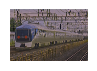

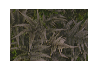

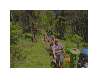

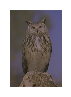

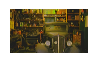

scale:4      eval psnr: 16.89     ssim: 0.6835
best epoch: 0, psnr: 16.886909, ssim: 0.683489


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

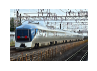

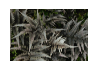

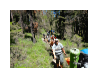

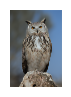

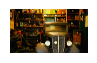

scale:4      eval psnr: 22.19     ssim: 0.6314
best epoch: 24, psnr: 22.193346, ssim: 0.631382


In [ ]:
trainer.train()

In [ ]:
# torch.save(net_g.state_dict(), "net_g_model.pth")
# torch.save(net_d.state_dict(), "net_d_model.pth")

In [14]:
new_gen = Generator_RRDB(num_in_ch=3, num_out_ch=3, scale=4, num_feat=64, num_block=23, num_grow_ch=32)
new_gen.load_state_dict(torch.load("net_g_model.pth"))
new_gen.eval().to(device)

Generator_RRDB(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rrdb): Sequential(
    (rrdb0): RRDB(
      (rdblk1): rrdb_block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdblk2): rrdb_block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), paddin

In [10]:
valset1 = EvalDataset(load_dataset('eugenesiow/Set14', 'bicubic_x4', split='validation'))
valset2 = EvalDataset(load_dataset('eugenesiow/Urban100', 'bicubic_x4', split='validation'))

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset set14 downloaded and prepared to /root/.cache/huggingface/datasets/eugenesiow___set14/bicubic_x4/1.0.0/aeded014732d03e88321cef292f60e9ff6cc73e271c273302a82f089f7654d13. Subsequent calls will reuse this data.


Generating validation split: 0 examples [00:00, ? examples/s]

Dataset urban100 downloaded and prepared to /root/.cache/huggingface/datasets/eugenesiow___urban100/bicubic_x4/1.0.0/e13138d3e2554d88602e010c8e53f6ee8e5e2232fe1b9be906a293587c3fb983. Subsequent calls will reuse this data.


In [ ]:
trainer = Trainer(new_gen, net_d, opt_g, opt_d, train_dataset=None, eval_dataset=valset2, num_epochs=25)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
trainer.eval(0)

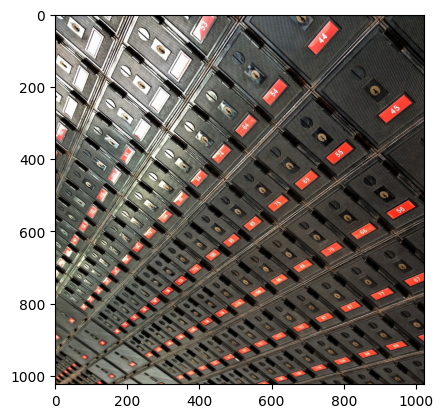

In [11]:
from google.colab.patches import cv2_imshow
lq, hq = valset2[5]
plt.imshow(hq.transpose(1, 2, 0))

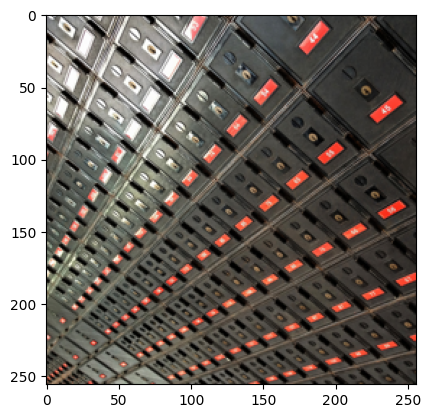

In [12]:
plt.imshow(lq.transpose(1, 2, 0))

(3, 1024, 1024)


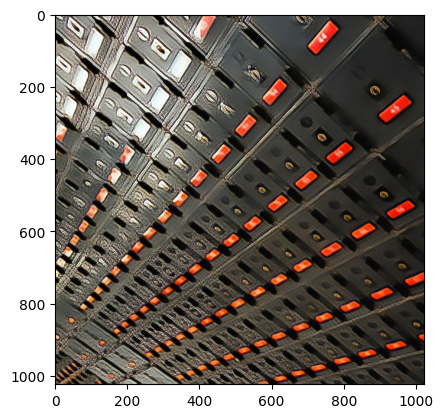

In [15]:
with torch.no_grad():
  up = new_gen(torch.tensor(lq).unsqueeze(0).to(device)).squeeze().detach().cpu().numpy()
print(up.shape)
plt.imshow(up.transpose(1, 2,0))